# general imports

In [1]:
from __future__ import division, print_function

from functools import partial
import copy

import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

mpl.rcParams.update( {
        'axes.labelsize': 'large',
        'axes.linewidth': 2,
        'legend.fancybox': True,
        'legend.fontsize': 'large',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
        'xtick.major.pad': 14,
        'ytick.major.pad': 14,
        'font.size': 20
} )

In [2]:
# sets the PyHEADTAIL directory etc.
try:
    from settings import *
except:
    pass

# PyHEADTAIL imports

In [3]:
from PyHEADTAIL.particles.generators import (
    ParticleGenerator, RF_bucket_distribution, gaussian2D, gaussian2D_asymmetrical
)
from PyHEADTAIL.particles.slicing import SliceSet, UniformBinSlicer
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems
from PyHEADTAIL.trackers.rf_bucket import RFBucket
from PyHEADTAIL.spacecharge.spacecharge import LongSpaceCharge

PyHEADTAIL v1.12.4.7




# Setting up the machine and functions

In [4]:
# general parameters
n_slices = 400
macroparticlenumber = int(5e4)

# machine
circ   = 6911.
R      = circ/(2*np.pi)
alpha  = 18**-2 # i.e. E_transition = 18 * m_p * c**2 = 16.89e9

energy = 26e9
gamma  = energy/(m_p/e*c**2)
p0     = m_p*np.sqrt(gamma**2-1)*c

eta    = alpha - gamma**-2
V      = [4e6, 0e5]
h      = [4620, 18480]
if eta > 0:
    phi = np.array([0, 0])
else:
    phi = np.array([np.pi, np.pi])
phi_offset = np.array([0, 0])
phi += phi_offset
intensity = 8e11
sigx = 1e-4
sigy = 1e-4
sigz = 0.23 * 0.5
sigdp = 1e-3

# acceleration
beta          = np.sqrt(1-1/gamma**2)
normalisation = 1/circ * e * circ/(beta*c)
dp_increment   = 1e6 * normalisation/p0
T0            = circ/(beta*c)

# analytic functions
threshold = 1e-10
def lambda_(z, z_offset=0):
    z = np.atleast_1d(z - z_offset)
    value = intensity / (np.sqrt(2*np.pi)*sigz) * np.exp(-z**2/(2*sigz**2))
    empty = np.zeros(len(value))
    clean = np.where(value > threshold, value, empty)
    clean[np.logical_and(z < 0, clean == 0)] -= threshold
    clean[np.logical_and(z >= 0, clean == 0)] += threshold
    return clean

def lambda_prime(z, z_offset=0):
    z = np.atleast_1d(z - z_offset)
    value = -intensity / (np.sqrt(2*np.pi) * sigz**3) * z * np.exp(-z**2/(2*sigz**2))
    empty = np.zeros(len(value))
    clean = np.where(lambda_(z) > threshold, value, empty)
    clean[np.logical_and(z < 0, clean == 0)] -= threshold
    clean[np.logical_and(z >= 0, clean == 0)] += threshold
    return clean

# Let's go

## Longitudinal space charge potential + RF bucket

The longitudinal beam self-field adds to the potential of the radio frequency bucket. This may enhance or cancel phase focusing depending on whether the bunch is accelerating (or decelerating) and whether the machine operates above or below transition.

To reflect additional fields such as longitudinal space charge in the `RFBucket` one may use its method `add_fields`. In order to calculate the total Hamiltonian, fix points for separatrices etc., `RFBucket` needs both the force and its integrated potential from such a superimposed field.

Note: by default, an `RFBucket` provided by `RFSystems.get_bucket(bunch)` only contains information about the external radio frequency fields -- space charge fields would have to be added manually.

We create a 6D Gaussian beam along with a `LongSpaceCharge` which can calculate the force and potential of the beam (based on the longitudinal discretisation in slices):

In [5]:
epsn_z = sigz * sigdp * 4 * np.pi * p0/e
p_increment = dp_increment * p0

slicer = UniformBinSlicer(n_slices, n_sigma_z=4)

beam = ParticleGenerator(
    macroparticlenumber, intensity, e, m_p, circ, gamma, 
    distribution_x=gaussian2D(sigx),
    distribution_y=gaussian2D(sigy),
    distribution_z=gaussian2D_asymmetrical(sigz, sigdp)
).generate()


long_sc = LongSpaceCharge(slicer, 5e-2, circ)

longitudinal_map = RFSystems(circ, h, V, phi, [alpha], gamma, 
                             p_increment=p_increment, charge=e, mass=m_p)
rfbucket = longitudinal_map.get_bucket(beam)
rfbucket_wosc = copy.deepcopy(rfbucket)

# align bunch longitudinally around centre of bucket
beam.z += rfbucket.z_sfp_extr
print ('beam.mean_z    = %e\nrfbucket.z_sfp = %e' % 
       (beam.mean_z(), rfbucket.z_sfp))
print ('')
print ('beam.epsn_z    = %e\nnominal epsn_z = %e' % 
       (beam.epsn_z(), epsn_z))

slices = beam.get_slices(slicer, statistics=['sigma_x', 'sigma_y'])

rfbucket.add_fields([long_sc.make_force(beam)], 
                    [long_sc.make_potential(beam)])

beam.mean_z    = 5.984908e-02
rfbucket.z_sfp = 6.015758e-02

beam.epsn_z    = 1.252139e-01
nominal epsn_z = 1.252499e-01


We plot the longitudinal line charge density $\lambda(z)$ along with its derivative $\lambda'(z)$ providing the space charge field:

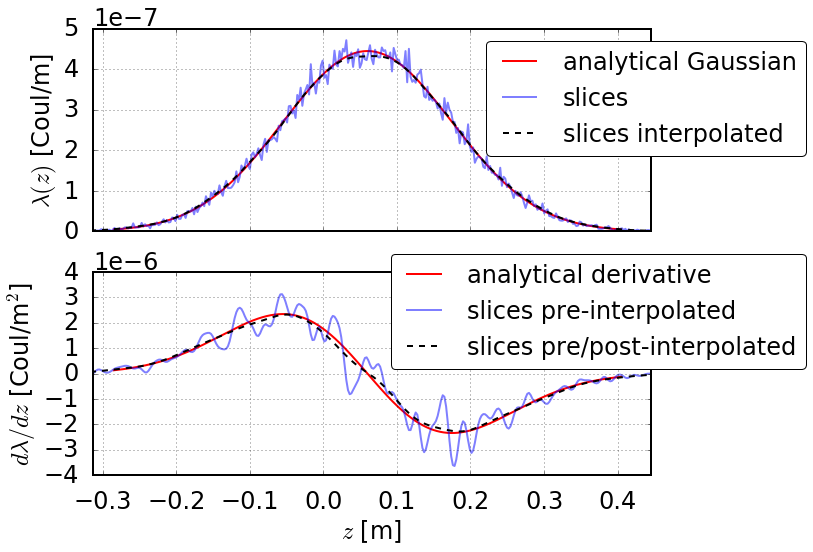

In [6]:
num = 2000
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,8))

zz = np.linspace(beam.mean_z() - 3*sigz, beam.mean_z() + 3*sigz, num)

ax1.plot(zz, lambda_(zz, beam.mean_z()) * e, 'red', lw=2, label='analytical Gaussian')
ax1.plot(slices.z_centers, 
         slices.n_macroparticles_per_slice * beam.particlenumber_per_mp / 
             slices.slice_widths * beam.charge, 
         'blue', alpha=0.5, lw=2, label='slices')
ax1.plot(slices.z_centers, slices.lambda_z(slices.z_centers), 
         '--', c='black', lw=2, label='slices interpolated')
ax1.grid(True)
ax1.set_ylabel('$\lambda(z)$ [Coul/m]')
ax1.legend(bbox_to_anchor=(1.3, 1))

ax2.plot(zz, lambda_prime(zz, beam.mean_z()) * e, 'red', 
         lw=2, label='analytical derivative')
ax2.plot(slices.z_centers, 
         slices.lambda_prime_bins(sigma=2) / slices.slice_widths, 
         'blue', alpha=0.5, lw=2, label='slices pre-interpolated')
ax2.plot(slices.z_centers, slices.lambda_prime_z(slices.z_centers), 
         '--', c='black', lw=2, label='slices pre/post-interpolated')
ax2.grid(True)
ax2.get_yaxis().get_major_formatter().set_powerlimits((-3,4))
ax2.legend(bbox_to_anchor=(1.3, 1.15))

plt.xlim(zz[0]*1.1, zz[-1]*1.1)

ax2.set_ylabel('$d\lambda/d z$ [Coul/m${}^2$]')
ax2.set_xlabel('$z$ [m]')

plt.show()

Correspondingly, the added longitudinal space charge field deforms the RF bucket's force, potential and therefore its Hamiltonian along with its separatrices. The preset parameters in this notebook give an accelerating bucket below transition -- this results in the proton bunch to enhance phase focusing, the separatrix of the superposed potentials' Hamiltonian (in solid purple) shows a larger acceptance than the non-deformed pure RF bucket's separatrix (in dashed green):

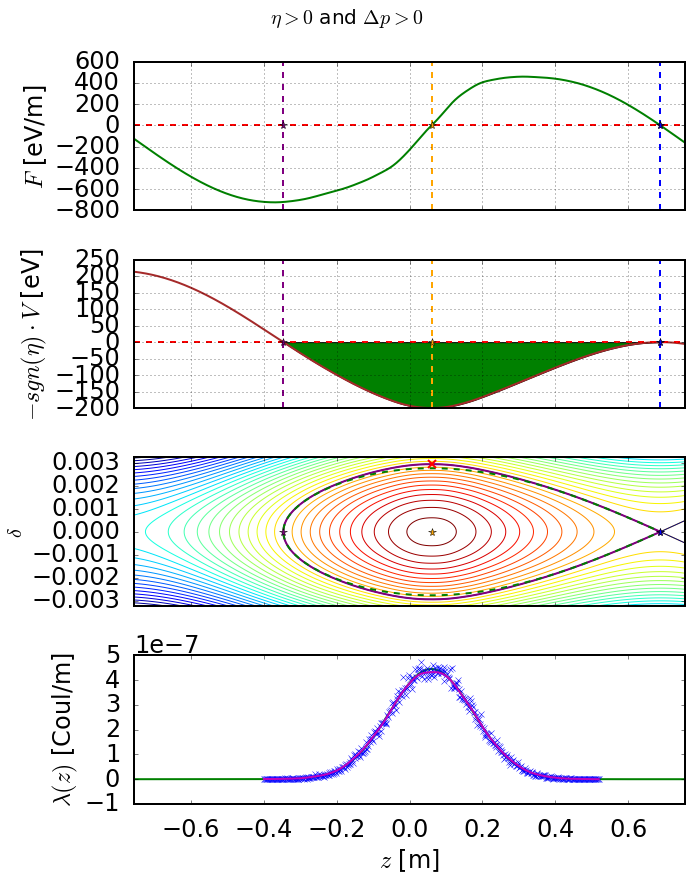

In [7]:
ppmax = np.maximum(rfbucket.dp_max(rfbucket.z_ufp_separatrix), 
                rfbucket_wosc.dp_max(rfbucket.z_ufp_separatrix))

pp = np.linspace(-1.1*ppmax, 1.1*ppmax, num)

zz = np.linspace(*rfbucket.interval, num=num)
ZZ, PP = np.meshgrid(zz, pp)
orig_shape = ZZ.shape
ZZ = ZZ.reshape(-1)
PP = PP.reshape(-1)
hh = rfbucket.hamiltonian(ZZ, PP, make_convex=True)
ZZ = ZZ.reshape(orig_shape)
PP = PP.reshape(orig_shape)
hh = hh.reshape(orig_shape)

hc = rfbucket.separatrix
hc_wosc = rfbucket_wosc.separatrix

ap = []
ap.append(rfbucket.z_left)
ap += list(rfbucket.z_sfp)
ap += list(rfbucket.z_ufp)
ap.append(rfbucket.z_right)
if p_increment == 0:
    ap.append(np.pi-rfbucket.z_sfp_extr)
    
ac = ['purple'] + ['orange']*len(rfbucket.z_sfp) + ['red']*len(rfbucket.z_ufp) + ['b']
if rfbucket.eta0 * rfbucket.p_increment < 0:
    ac[0], ac[-1] = ac[-1], ac[0]

zz_bucket = zz[rfbucket.is_in_separatrix(zz, 0, margin=-0.001)]
zz_bucket_wosc = zz[rfbucket_wosc.is_in_separatrix(zz, 0, margin=-0.001)]

figtitle = ""
if eta > 0:
    figtitle += "$\eta > 0$ and "
elif eta < 0:
    figtitle += "$\eta < 0$ and "
else:
    figtitle += "$\eta = 0$ and "
if dp_increment > 0:
    figtitle += "${\Delta}p > 0$"
elif dp_increment < 0:
    figtitle += "${\Delta}p < 0$"
else:
    figtitle += "${\Delta}p = 0$"

fig1, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10,12), sharex=True)

ax1.plot(zz, rfbucket.total_force(zz)/e, 'g', lw=2)
ax1.set_ylabel('$F~$ [eV/m]')
ax1.grid()

ax2.plot(zz, -np.sign(rfbucket.eta0) * rfbucket.total_potential(zz)/e, 'brown', lw=2)
ax2.fill_between(zz_bucket, -np.sign(rfbucket.eta0) * rfbucket.total_potential(zz_bucket)/e, 
                 0, facecolor='green', interpolate=True)
ax2.set_ylabel('$-sgn(\eta) \cdot V~$ [eV]')
ax2.grid()

ax3.contour(ZZ, PP, hh, 40)#, cmap=cm.Accent)
ax3.contour(ZZ, PP, hh, levels=[0], c='purple')
ax3.plot(zz_bucket, +hc(zz_bucket), c='purple', lw=2)
ax3.plot(zz_bucket, -hc(zz_bucket), c='purple', lw=2)
ax3.plot(zz_bucket_wosc, +hc_wosc(zz_bucket_wosc), '--g', lw=2)
ax3.plot(zz_bucket_wosc, -hc_wosc(zz_bucket_wosc), '--g', lw=2)
ax3.set_ylabel('$\delta$', fontsize=20)

for ax in ax1, ax2:
    ax.axhline(0, c='r', ls='--', lw=2)
    for p, cl in zip(ap, ac):
        ax.axvline(p, c=cl, ls='--', lw=2)
for p, cl in zip(ap, ac):
    ax1.plot(p, rfbucket.total_force(p), '*', c=cl, ms=8)
    ax2.plot(p, -np.sign(eta) * rfbucket.total_potential(p), '*', c=cl, ms=8)
    ax3.plot(p, 0, '*', c=cl, ms=8)

ax4.plot(zz, lambda_(zz, beam.mean_z()) * e, 'green', lw=2)
ax4.plot(slices.z_centers, slices.lambda_z(slices.z_centers, smoothen=False), 'xb')
ax4.plot(slices.z_centers, slices.lambda_z(slices.z_centers), 'm', lw=2)
ax4.set_ylabel('$\lambda(z)$ [Coul/m]')

ax3.plot(ap[1], hc(ap[1]), 'x', c='r', ms=8, mew=2)

ax4.set_xlabel('$z$ [m]')
plttitle = plt.suptitle(figtitle, y=1.025, fontsize=20)

plt.xlim(rfbucket.interval)

plt.tight_layout()

# plt.savefig('bucket.pdf', bbox_extra_artists=(plttitle,), bbox_inches='tight')

plt.show()

If you are motivated, play around with the transition energy (momentum compaction factor `alpha`) to change the sign of the slippage factor $\eta$ as well as the sign of the momentum change `dp_increment`. The plots should adjust.